# Light Beads Microscopy Demo Pipeline 

## Pipeline Steps

### Pre-Processing:
- Extract ScanImage metadata
- Correct Bi-Directional Offset for each ROI
- Calculates and corrects the MROI seams (IN PROGRESS)
### Motion Correction

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

### Segmentation

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.



### Imports and general setup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
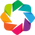

In [22]:
import sys
import os
from pathlib import Path
import cv2
sys.path.append('../util/')  # TODO: Take this out when we upload to pypi
sys.path.append('../exclude/')  # TODO: Take this out when we upload to pypi
import scanreader
import util
from scan import fix_scan_phase, return_scan_offset

import bokeh.plotting as bpl
import holoviews as hv
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import caiman as cm

bpl.output_notebook()
hv.notebook_extension('bokeh')
%matplotlib inline

## Set up a few helper functions for plotting, logging and setting up our environment

In [15]:
def plot_frame(img, title='', savepath='', **kwargs):
    fig, ax = plt.subplots()
    ax.imshow(img, **kwargs)
    fig.suptitle(f'{title}')
    fig.tight_layout()
    if savepath:
        plt.savefig(savepath, **kwargs)
    plt.show()

# set up logging
logging.basicConfig(format="{asctime} - {levelname} - [{filename} {funcName}() {lineno}] - pid {process} - {message}",
                    filename=None, 
                    level=logging.WARNING, style="{") # this shows you just errors that can harm your program
                    # level=logging.DEBUG, style="{") # this shows you general information that developers use to trakc their program 
                    # (be careful when playing movies, there will be a lot of debug messages)

# set env variables 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
chan_order = np.array([ 1, 5, 6, 7, 8, 9, 2, 10, 11, 12, 13, 14, 15, 16, 17, 3, 18, 19, 20, 21, 22, 23, 4, 24, 25, 26, 27, 28, 29, 30])  # this is specific to our dataset

## Extract data using scanreader, joining contiguous ROI's, and plot our mean image

Our ScanReader object contains all of the properties needed to keep track of our raw data. ScanImage metadata is stored alongside header metadata, this ScanImage specific data is what's needed to assemble frames from constituent ROIs.

In [17]:
datapath = Path('/data2/fpo/data/')                 # string pointing to directory containing your data
tiffs = [x for x in datapath.glob('*.tif')]         # this accumulates a list of every filepath which contains a .tif file

reader = scanreader.read_scan(str(tiffs[0]), join_contiguous=False)
print(f"Number of Planes: {reader.num_channels}")
print(f"Number of ROIs: {reader.num_fields}")
print(f"Total frames (single .tiff) {reader.num_frames}")
print(f"Total frames (all .tiffs) {reader.num_requested_frames}")

Number of Planes: 30
Number of ROIs: 2
Total frames (single .tiff) 1750
Total frames (all .tiffs) 7000


## Scan Phase Correction

.. img:: img/scanpath+exposure.png

Methods:
1) Linear interpolation
2) Phase - cross correlation

In [5]:
roi_1 = reader[0]
slice_plane = roi_1[:,:,5,:]
phase_angle =  util.compute_raster_phase(slice_plane[:,:, 400], reader.temporal_fill_fraction)
corrected_li = util.correct_raster(slice_plane, phase_angle, reader.temporal_fill_fraction)

In [23]:
from bokeh.models import Range1d

def bounds_hook(plot, elem, xbounds=None, ybounds=None):
    x_range = plot.handles['plot'].x_range
    y_range = plot.handles['plot'].y_range
    if xbounds is not None:
        x_range.bounds = xbounds
    else:
        x_range.bounds = x_range.start, x_range.end 
    if ybounds is not None:
        y_range.bounds = ybounds
    else:
        y_range.bounds = y_range.start, y_range.end 

aspect_ratio = slice_plane.shape[1] / slice_plane.shape[0]

range_x = Range1d(start=0, end=slice_plane.shape[1])
range_y = Range1d(start=0, end=slice_plane.shape[0])

plot_width = 600
plot_height = int(plot_width / aspect_ratio)

image1 = hv.Image(slice_plane[:,:,400]).opts(
    width=plot_width,
    height=plot_height,
    title="Original Image",
    tools=['hover', 'pan', 'wheel_zoom'],
    cmap='gray', 
    hooks=[bounds_hook])

image2 = hv.Image(corrected_li[:,:,400]).opts(
    width=plot_width,
    height=plot_height,
    title="Corrected Image",
    tools=['hover', 'pan', 'wheel_zoom'],
    cmap='gray',
    hooks=[bounds_hook], 
    )

# Combine the images into a layout
layout = image1 + image2

# Display the layout
# hv.save(layout, '../docs/img/comparison.html')
bpl.show(hv.render(layout))

In [27]:
print(image1)

:Image   [x,y]   (z)


In [20]:
ph = return_scan_offset(roi_1, 1)
corrected_pc = fix_scan_phase(roi_1, ph, 1)

In [24]:
image1 = hv.Image(roi_1[:,:,4,100]).opts(
    width=plot_width,
    height=plot_height,
    title="Original Image",
    tools=['hover', 'pan', 'wheel_zoom'],
    cmap='gray', 
    hooks=[bounds_hook])

image2 = hv.Image(corrected_pc[:,:,4,100]).opts(
    width=plot_width,
    height=plot_height,
    title="Corrected Image",
    tools=['hover', 'pan', 'wheel_zoom'],
    cmap='gray',
    hooks=[bounds_hook], 
    )

layout = image1 + image2

# Display the layout
# hv.save(layout, '../docs/img/comparison.html')
bpl.show(hv.render(layout))

## Join Contiguious ROI's

Setting `join_contiguous=True` will combine ROI's with the following constraints:
1) Must be the same size/shape
2) Must be located in the same scanning depth
3) Must be located in the same slice
- ROI can be directly left, right, above or below the adjacent ROI's

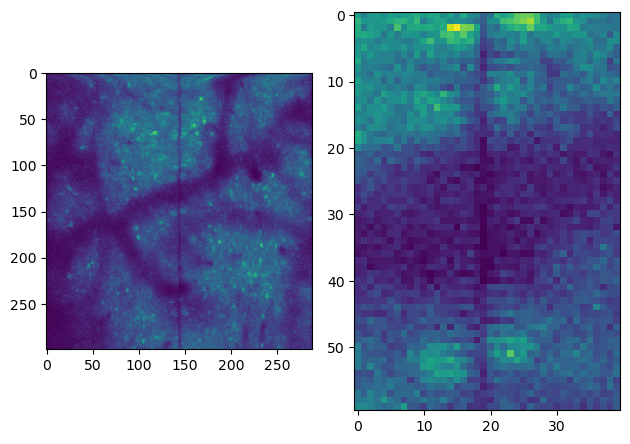

In [25]:
# Create another reader, without joining contiguous fields
contig = scanreader.read_scan(str(tiffs[0]), join_contiguous=True) 
num_roi=len(contig)        # we now have a single ROI due to the merging 
data = contig[0]
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(data[:,:, 5, 400])
ax[1].imshow(data[100:160,125:165,5,400])
plt.tight_layout()
plt.show()

In [ ]:
do_stats = False
if do_stats:
    result_dict = {}
    for field_id, data in enumerate(reader_cont):
        print(field_id)
        for channel in range(reader_cont.num_channels):
            key_str = f"{field_id}_{channel}"
            results = util.performance.map_frames(
                util.performance.parallel_quality_metrics,
                reader_cont,
                field_id=field_id,
                channel=channel,
            )

            # Reduce
            mean_intensities = np.zeros(reader_cont.num_frames)
            contrasts = np.zeros(reader_cont.num_frames)
            for frames, chunk_mis, chunk_contrasts, _ in results:
                mean_intensities[frames] = chunk_mis
                contrasts[frames] = chunk_contrasts

            result_dict[key_str] = {
                "mean_intensities": mean_intensities,
                "contrasts": contrasts,
            }

0
Using 10 processes
Fri May  3 13:33:05 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:33:05 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:33:32 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:33:32 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:33:58 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:33:59 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:34:25 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:34:26 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:34:52 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:34:53 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:35:19 2024 Processing frames: slice(1553, 1750, None)
Fri May  3 13:35:20 2024 Processing frames: slice(0, 1553, None)
Using 10 processes
Fri May  3 13:35:47 2024 Processing frames: slice(1553, 1750, None)

Process Process-118:
Process Process-117:
Exception ignored in: <function _releaseLock at 0x7fd64dfb0ae0>
Traceback (most recent call last):
  File "/home/foconnell/miniconda3/envs/mbo-caiman/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Process Process-113:
Process Process-115:
Process Process-116:
Process Process-114:
Process Process-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/foconnell/miniconda3/envs/mbo-caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/foconnell/miniconda3/envs/mbo-caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/foconnell/miniconda3/envs/mbo-caiman/lib/python3.11/multiprocess

Using 10 processes


KeyboardInterrupt: 

## Motion Correction: CaImAn - NORMCorre

In [8]:
slice = reader[0][:,:,5,:]
movie = cm.movie(slice, start_time=2, fr=reader.fps)
downsampling_ratio = 0.2  # subsample 5x
movie = movie.resize(fz=downsampling_ratio)
# movie.play(gain=1.3, backend='embed_opencv')

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [10]:
import numpy as np
max_projection_orig = np.max(movie, axis=0)
correlation_image_orig = cm.local_correlations(movie, swap_dim=False)
correlation_image_orig[np.isnan(correlation_image_orig)] = 0 # get rid of NaNs, if they exist

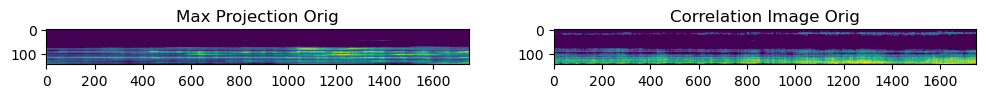

In [13]:
f, (ax_max, ax_corr) = plt.subplots(1,2, figsize=(12,6))
ax_max.imshow(max_projection_orig, 
              cmap='viridis',
              vmin=np.percentile(np.ravel(max_projection_orig),50), 
              vmax=np.percentile(np.ravel(max_projection_orig),99.5));
ax_max.set_title("Max Projection Orig", fontsize=12);

ax_corr.imshow(correlation_image_orig, 
               cmap='viridis', 
               vmin=np.percentile(np.ravel(correlation_image_orig),50), 
               vmax=np.percentile(np.ravel(correlation_image_orig),99.5));
ax_corr.set_title('Correlation Image Orig', fontsize=12);